In [52]:
import sys
import ase
import nglview as nv
import numpy as np

sys.path.append('../')


In [53]:
generated_paths = {
    "Symphony (train)": "/Users/ameyad/Documents/spherical-harmonic-net/conditional_generation/symphony/train/qm9_bessel_embedding_attempt6_edm_splits/e3schnet_and_nequip/interactions=3/l=5/position_channels=2/channels=64/fait=1.0/pit=1.0/step=9930000/molecules/",
    "Symphony (test)": "/Users/ameyad/Documents/spherical-harmonic-net/conditional_generation/symphony/test/qm9_bessel_embedding_attempt6_edm_splits/e3schnet_and_nequip/interactions=3/l=5/position_channels=2/channels=64/fait=1.0/pit=1.0/step=9930000/molecules/",
    "GSchNet (train)": "/Users/ameyad/Documents/spherical-harmonic-net/conditional_generation/gschnet_generated_train_and_test/train",
    "GSchNet (test)": "/Users/ameyad/Documents/spherical-harmonic-net/conditional_generation/gschnet_generated_train_and_test/test",
}

In [54]:
from analyses.metrics import *

In [55]:
from symphony.data import qm9
all_mols = qm9.load_qm9("../qm9_data", use_edm_splits=True, check_molecule_sanity=False)
num_mols = 1000
test_mols = all_mols[-num_mols:]
train_mols = all_mols[:num_mols]

def get_fragment_list(mols: Sequence[ase.Atoms], num_mols: int):
    fragments = []
    H_removed = []
    for i in range(num_mols):
        mol = mols[i]
        num_atoms = len(mol)
        for j in range(num_atoms):
            fragment = ase.Atoms(
                positions=np.vstack([mol.positions[:j], mol.positions[j + 1 :]]),
                numbers=np.concatenate([mol.numbers[:j], mol.numbers[j + 1 :]]),
            )
            fragments.append(fragment)
            H_removed.append(mol.numbers[j] == 1)
    return fragments, H_removed

# Ensure that the number of molecules is a multiple of num_seeds_per_chunk.
train_mol_list, train_H_removed = get_fragment_list(train_mols, num_mols)
test_mol_list, test_H_removed = get_fragment_list(test_mols, num_mols)

[16:00:11] Warning: molecule is tagged as 3D, but all Z coords are zero
[16:00:12] Warning: molecule is tagged as 3D, but all Z coords are zero


../qm9_data/edm_splits.npz


In [56]:
def get_key_fn(model):
    assert ("Symphony" in model) ^ ("GSchNet" in model)
    def key_fn(x):
        if "GSchNet" in model:
            tokens = x.removesuffix(".xyz").split('_')
            return (int(tokens[1][3:]), int(tokens[2]))
        else:
            return int(x.removesuffix(".xyz").split("=")[-1])
    return key_fn


def get_all_molecules(model: str, molecules_dir: str) -> List[Chem.Mol]:
    """Returns all molecules in a directory."""
    molecules = []
    molecules_files = [f for f in os.listdir(molecules_dir) if f.endswith(".xyz")]
    for molecules_file in sorted(molecules_files, key=get_key_fn(model)):
        if not molecules_file.endswith(".xyz"):
            continue

        molecules_file = os.path.join(molecules_dir, molecules_file)
        mol = xyz_to_rdkit_molecule(molecules_file)
        molecules.append(mol)

    return molecules


all_generated_molecules = {
    model: get_all_molecules(model, molecules_dir) for model, molecules_dir in generated_paths.items()
}

In [57]:
print(np.mean(train_H_removed))

0.5127637189213134


In [58]:
for model, generated_molecules in all_generated_molecules.items():
    if "GSchNet" in model:
        generated_molecules_with_H_removed = generated_molecules
    else:
        if "train" in model:
            H_removed = train_H_removed
        else:
            H_removed = test_H_removed

        generated_molecules_with_H_removed = []
        for molecule, H_removed in zip(generated_molecules, H_removed):
            if H_removed:
                generated_molecules_with_H_removed.append(molecule)
    
    validity_fraction = compute_validity(generated_molecules_with_H_removed, get_all_valid_molecules(generated_molecules_with_H_removed))
    print(f"{model}: {100 * validity_fraction:0.2f}")

Symphony (train): 95.57
Symphony (test): 95.43
GSchNet (train): 97.91
GSchNet (test): 98.15


In [59]:
# Original submission: conditional validity experiment
# Symphony: 4950000: 98.5%
# Symphony: 7530000: 96.65%
# Symphony: 9930000: 95.5%
# Symphony: 28600000: 94%

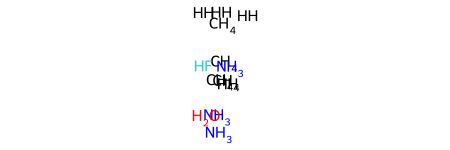

In [60]:
all_generated_molecules["Symphony (train)"][0]

In [61]:
generated_molecules_with_H_removed = []
true_molecules_with_H_removed = []
for generated_molecule, true_molecule, H_removed in zip(all_generated_molecules["Symphony (train)"], train_mol_list, train_H_removed):
    if H_removed:
        generated_molecules_with_H_removed.append(generated_molecule)
        true_molecules_with_H_removed.append(true_molecule)

print(generated_molecules_with_H_removed[0], true_molecules_with_H_removed[0])
ase_mols = [
    ase.Atoms(
        symbols=[atom.GetSymbol() for atom in generated_molecules_with_H_removed[0].GetAtoms()],
        positions=generated_molecules_with_H_removed[0].GetConformer().GetPositions(),
    ),
    true_molecules_with_H_removed[0]]

nv.show_ase(ase_mols[0])


<rdkit.Chem.rdchem.Mol object at 0x3085246d0> Atoms(symbols='C3FN2OCNH3', pbc=False)


NGLWidget()

In [62]:
nv.show_ase(ase_mols[1])

NGLWidget()

In [63]:
print(len(all_generated_molecules["GSchNet (train)"]))
print(len(train_mol_list))

print(len(all_generated_molecules["GSchNet (test)"]))
print(len(test_mol_list))

9254
18059
9262
18071


In [64]:
invalid_molecules_symphony = [mol for mol in all_generated_molecules["Symphony (train)"][:100] if not check_molecule_validity(mol)]
invalid_molecules_gschnet = [mol for mol in all_generated_molecules["GSchNet (train)"][:100] if not check_molecule_validity(mol)]

In [65]:
invalid_molecules_ase = [
    ase.Atoms(
        symbols=[atom.GetSymbol() for atom in mol.GetAtoms()],
        positions=mol.GetConformer().GetPositions(),
    )
    for mol in invalid_molecules_symphony
]
nv.show_ase(invalid_molecules_ase[2], gui=True)        

NGLWidget()